In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import yfinance as yf
from scipy.stats import norm
import pandas as pd



Select a Canadian company, which has both historical stock prices as well as bond prices available on a given day.

Use the Merton/KMV model to calculate the default probability of that company over time.

Use a CreditMetrics-type model to calculate the default probability of that company over time.

In [45]:
LBLCF_stock = yf.download("L.TO", start="2023-03-13", end="2024-03-13")
print(LBLCF_stock.head())
LBLCF_stock.shape

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2023-03-13  115.000000  115.879997  113.739998  114.589996  112.585808  371100
2023-03-14  114.440002  114.940002  113.199997  114.169998  112.571007  593100
2023-03-15  113.949997  116.739998  112.110001  116.650002  115.016273  536600
2023-03-16  116.510002  116.820000  115.260002  115.800003  114.178185  390600
2023-03-17  114.220001  116.330002  113.940002  116.059998  114.434532  952000


(252, 6)

In [46]:
print(LBLCF_stock['Adj Close'].mean())

121.5595149388389


In [47]:
daily_returns = LBLCF_stock['Adj Close'].pct_change().dropna()
volatility1 = np.sqrt(252) * daily_returns.std()
print("Annualized Volatility:", volatility1)

Annualized Volatility: 0.1743694751508588


MERTON MODEL

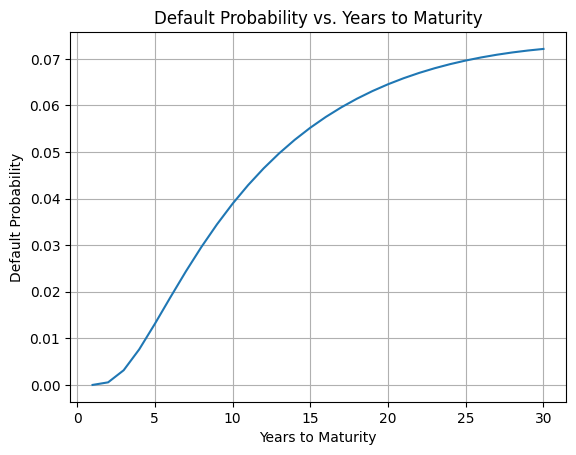

In [42]:
import matplotlib.pyplot as plt

def merton_default_probability(stock_price, debt, equity, volatility, risk_free_rate, time_to_maturity):

      d1 = (np.log(((38979000000)) / debt) + (risk_free_rate + (volatility ** 2)*0.5) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
      d2 = d1 - volatility * np.sqrt(time_to_maturity)
      default_prob = norm.cdf(-d2)
      return default_prob


debt = 	18173000000
volatility = volatility1
risk_free_rate = 0.0364
years_to_maturity = np.arange(1, 31)
default_probabilities2 = []
for maturity_year in years_to_maturity:
    time_to_maturity = maturity_year
    default_prob = merton_default_probability(LBLCF_stock['Adj Close'], debt, equity, volatility, risk_free_rate, time_to_maturity)
    default_probabilities2.append(default_prob)
plt.plot(years_to_maturity, default_probabilities2)
plt.title('Default Probability vs. Years to Maturity')
plt.xlabel('Years to Maturity')
plt.ylabel('Default Probability')
plt.grid(True)
plt.show()

CreditMetrics Model

In [16]:
file_path = 'TM.xls'
data = pd.read_excel(file_path)
TM = data.to_numpy()[ :, 1:]/100
print(TM)

[[0.9716 0.0083 0.0014000000000000002 0.0004 0.0002 0.0001 0.0001 0.0001
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0001 0.0179]
 [0.0233 0.9201 0.0109 0.0015 0.0003 0.0001 0.0 0.0 0.0002 0.0001 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0435]
 [0.0027 0.0339 0.8998999999999999 0.0146 0.0023 0.0008 0.0002 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0455]
 [0.0006 0.004699999999999999 0.0426 0.8881 0.0172 0.0033
  0.0007000000000000001 0.0002 0.0001 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0424]
 [0.0002 0.0009 0.0073 0.0415 0.887 0.0147 0.004 0.0006 0.0004 0.0002 0.0
  0.0001 0.0 0.0 0.0 0.0 0.0 0.0431]
 [0.0 0.0002 0.0022 0.0098 0.04769999999999999 0.8614
  0.015700000000000002 0.0042 0.0014000000000000002 0.0009 0.0002 0.0002
  0.0001 0.0 0.0001 0.0 0.0001 0.0559]
 [0.0 0.0002 0.0007000000000000001 0.0070999999999999995
  0.018500000000000003 0.0666 0.8236 0.019 0.005699999999999999 0.0024
  0.0002 0.0005 0.0 0.0 0.0003 0.0001 0.0002 0.0548]
 [0.0 0.0001 0.0002 0.0017000000000000001 0.0098 0.0213 0.0694 0.

In [ ]:
import numpy as np

def monte_carlo_prob_last_state(transition_matrix, initial_rating, T, num_simulations):
    num_states = transition_matrix.shape[0]
    num_last_state_reached = 0

    for _ in range(num_simulations):
        current_state = np.zeros(num_states)
        current_state[initial_rating] = 1

        for _ in range(T):
            pnow = np.dot(current_state, transition_matrix)
            rand_num = np.random.uniform()
            current_state = np.argmax(np.cumsum(pnow) > rand_num)

            if current_state == num_states - 1:
                num_last_state_reached += 1
                break

    probability_last_state = num_last_state_reached / num_simulations
    return probability_last_state


transition_matrix = TM
initial_rating = 8
num_simulations = 10000
T = 30

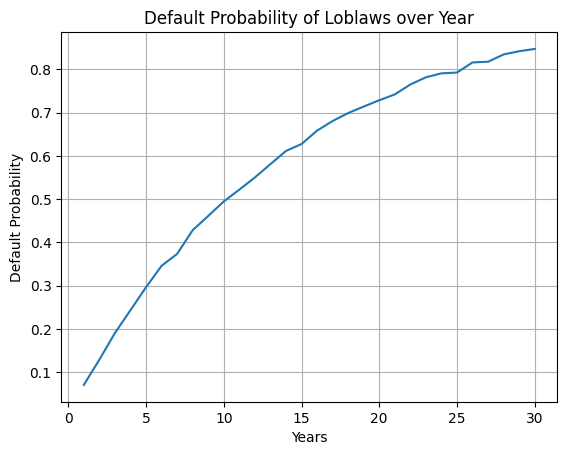

In [18]:
default_probabilities = [monte_carlo_prob_last_state(transition_matrix, initial_state, horizon, num_simulations) for horizon in years_to_maturity]
plt.plot(years_to_maturity, default_probabilities)
plt.title('Default Probability of Loblaws over Year')
plt.xlabel('Years')
plt.ylabel('Default Probability')
plt.grid(True)
plt.show()

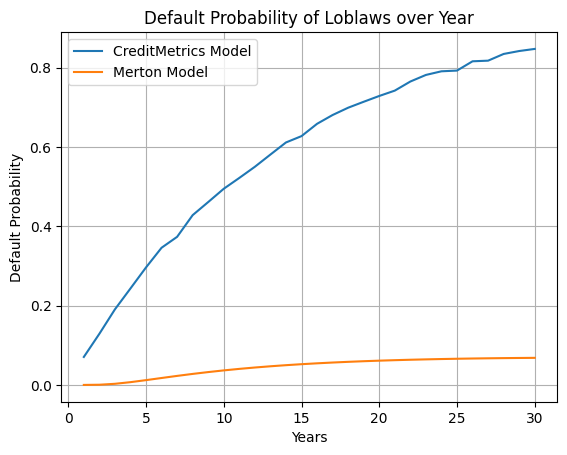

In [28]:
plt.plot(years_to_maturity, default_probabilities,label='CreditMetrics Model')
plt.plot(years_to_maturity, default_probabilities2,label='Merton Model')
plt.title('Default Probability of Loblaws over Year')
plt.xlabel('Years')
plt.ylabel('Default Probability')
plt.legend()
plt.grid(True)
plt.show()